In [1]:
import os

import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from gammapy.catalog import SourceCatalog4FGL
from gammapy.modeling.models import (
    EBLAbsorptionNormSpectralModel,
    GaussianPrior,
    Models,
    SkyModel,
)

from asgardpy.analysis import AsgardpyAnalysis
from asgardpy.config import AsgardpyConfig

In [3]:
# os.environ['GAMMAPY_DATA']

In [4]:
config_file = "../src/asgardpy/tests/config_test_ebl.yaml"
base_config = AsgardpyConfig.read(config_file)

# Updating path of test data

In [5]:
base_config.dataset1d.instruments[
    0
].dl4_dataset_info.dl4_dataset.input_dir = f"{os.environ['GAMMAPY_DATA']}PKS2155-steady/"

# Initiating the Analysis

In [6]:
analysis = AsgardpyAnalysis(base_config)

Setting logging config: {'level': 'INFO', 'filename': '', 'filemode': 'w', 'format': '', 'datefmt': ''}


# Running all steps

In [7]:
%%time
analysis.run()

Perform DL3 to DL4 process!
1 number of 1D Datasets given
List of DL4 files are: [PosixPath('/home/chaitanya/software/gammapy-datasets/1.2/PKS2155-steady/pks2155-304_steady.fits.gz')]
Analysis Step datasets-1d completed
Models have been associated with the Datasets
Perform DL4 to DL5 processes!
OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 70
	total stat : 6.13

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

Analysis Step fit completed
Using 10 processes to compute Energy bins
Analysis Step flux-points completed
The Chi2/dof value of the goodness of Fit is 6.11/8
and the p-value is 6.352e-01 and in Significance 0.47 sigmas
with best fit TS (Observed) as 6.108 and max fit TS (Expected) as -0.000


CPU times: user 344 ms, sys: 65.6 ms, total: 410 ms
Wall time: 803 ms


# Get the final products for the Observed, or EBL-absorbed, spectrum

In [8]:
analysis.datasets[0]

In [9]:
analysis.instrument_spectral_info

{'name': ['HESS'],
 'spectral_energy_ranges': [<Quantity [ 0.2       ,  0.31697864,  0.50237729,  0.79621434,  1.26191469,
              2.        ,  3.16978638,  5.02377286,  7.96214341, 12.61914689,
             20.        ] TeV>],
 'en_bins': 10,
 'free_params': 2,
 'DoF': 8,
 'max_fit_stat': -4.156675004196586e-13,
 'best_fit_stat': 6.107591214725009,
 'fit_chi2_sig': 0.4744467755747818,
 'fit_pval': 0.6351813439476275}

In [10]:
print(analysis.final_model[0])

SkyModel

  Name                      : PKS 2155-304
  Datasets names            : None
  Spectral model type       : CompoundSpectralModel
  Spatial  model type       : 
  Temporal model type       : 
  Parameters:
    index                         :      2.555   +/-    0.30             
    amplitude                     :   1.30e-11   +/- 1.9e-12 1 / (TeV s cm2)
    reference             (frozen):      1.000       TeV         
    alpha_norm            (frozen):      1.000                   
    redshift              (frozen):      0.116                   




<Axes: >

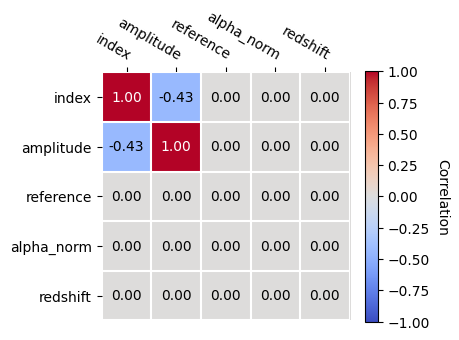

In [11]:
analysis.final_model.covariance.plot_correlation()

# Run the additional steps to get the products for Intrinsic, or EBL-deabsorbed spectrum

In [12]:
%%time
analysis.get_correct_intrinsic_model()

CPU times: user 11 ms, sys: 10.7 ms, total: 21.6 ms
Wall time: 6.94 ms


In [13]:
print(analysis.model_deabs)

SkyModel

  Name                      : PKS 2155-304
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : 
  Temporal model type       : 
  Parameters:
    index                         :      2.555   +/-    0.30             
    amplitude                     :   1.30e-11   +/- 1.9e-12 1 / (TeV s cm2)
    reference             (frozen):      1.000       TeV         




In [14]:
%%time
analysis.get_correct_ebl_deabs_flux_points()

Perform DL4 to DL5 processes!
Using 10 processes to compute Energy bins
Analysis Step flux-points completed
The Chi2/dof value of the goodness of Fit is 6.11/8
and the p-value is 6.352e-01 and in Significance 0.47 sigmas
with best fit TS (Observed) as 6.108 and max fit TS (Expected) as -0.000


CPU times: user 58.9 ms, sys: 93 ms, total: 152 ms
Wall time: 499 ms


<Axes: >

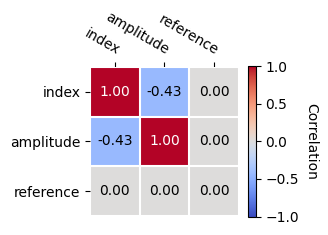

In [15]:
analysis.model_deabs.covariance.plot_correlation()

# Spectral plots

In [16]:
if len(analysis.final_model[0].parameters) > 3:
    nrow = int(np.sqrt(len(analysis.final_model[0].parameters)))
    ncol = int(np.ceil(len(analysis.final_model[0].parameters) / nrow))
else:
    ncol = len(analysis.final_model[0].parameters)
    nrow = 1
print(ncol, nrow)

3 2


CPU times: user 225 ms, sys: 165 ms, total: 390 ms
Wall time: 195 ms


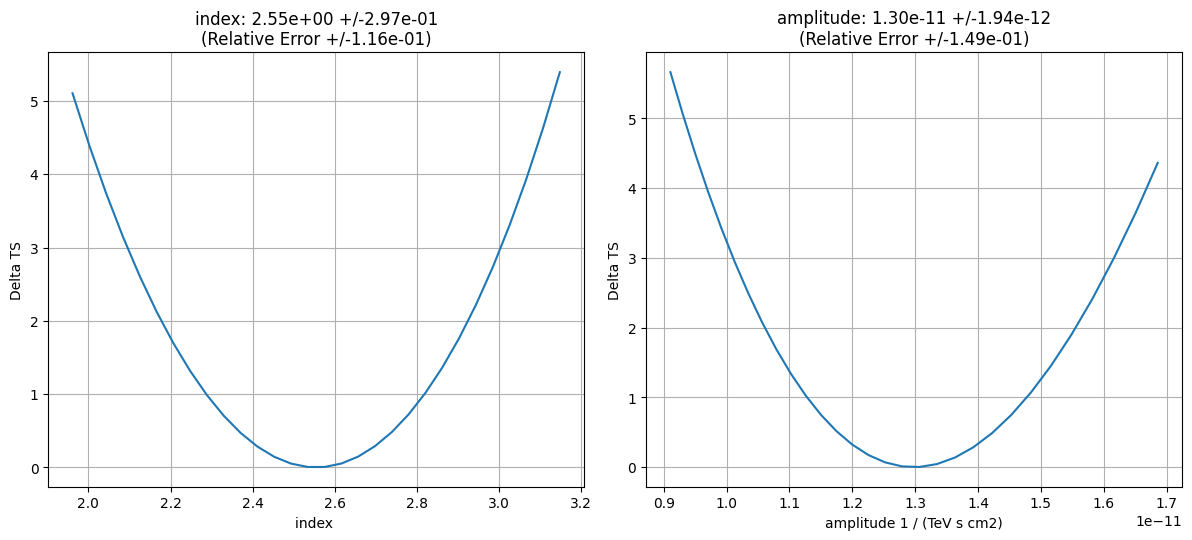

In [17]:
%%time
plt.figure(figsize=(ncol * 6, nrow * 5))
total_stat = analysis.fit_result.total_stat

for i, par in enumerate(analysis.final_model[0].parameters.free_parameters):
    par.scan_n_values = 30

    idx = analysis.final_model[0].parameters.index(par)
    name = Models(analysis.final_model[0]).parameters_unique_names[idx]

    profile = analysis.fit.stat_profile(datasets=analysis.datasets, parameter=par)

    plt.subplot(nrow, ncol, i + 1)
    plt.plot(profile[f"{name}_scan"], profile["stat_scan"] - total_stat)
    plt.xlabel(f"{par.name} {par.unit}")
    plt.ylabel("Delta TS")
    plt.grid()
    if par.value != 0:
        plt.title(f"{par.name}: {par.value:.2e} +/-{par.error:.2e}\n(Relative Error +/-{par.error/par.value:.2e})")
    else:
        plt.title(f"{par.name}: {par.value:.2e} +/-{par.error:.2e}")
plt.tight_layout()

Text(0.5, 1.0, 'TS Profile: EBL-absorbed spectrum')

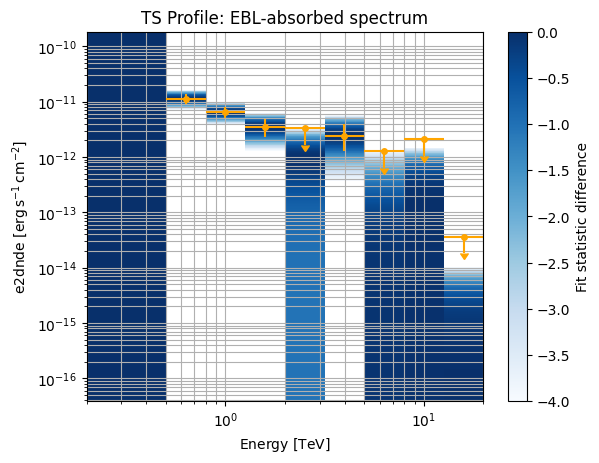

In [18]:
analysis.flux_points[0].plot_ts_profiles(sed_type="e2dnde")
analysis.flux_points[0].plot(sed_type="e2dnde", color="orange")

plt.grid(which="both")
plt.title("TS Profile: EBL-absorbed spectrum")

Text(0.5, 1.0, 'TS Profiles: EBL-deabsorbed spectrum')

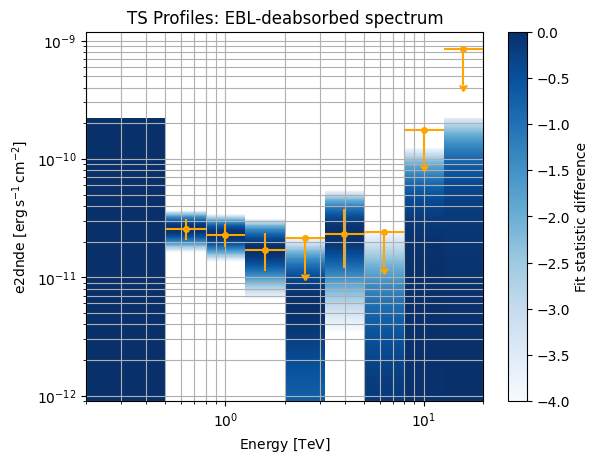

In [19]:
analysis.flux_points_deabs[0].plot_ts_profiles(sed_type="e2dnde")
analysis.flux_points_deabs[0].plot(sed_type="e2dnde", color="orange")

plt.grid(which="both")
plt.title("TS Profiles: EBL-deabsorbed spectrum")

In [20]:
analysis.flux_points[0].to_table(formatted=True, sed_type="e2dnde", format="gadf-sed")

e_ref,e_min,e_max,e2dnde,e2dnde_err,e2dnde_errp,e2dnde_errn,e2dnde_ul,ts,sqrt_ts,npred,npred_excess,stat,stat_null,is_ul,counts,success,norm_scan,stat_scan
TeV,TeV,TeV,TeV / (s cm2),TeV / (s cm2),TeV / (s cm2),TeV / (s cm2),TeV / (s cm2),,,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[1],float32[1],float64,float64,bool,float64[1],bool,float64[11],float64[11]
0.252,0.200,0.317,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.000,0.000,False,0.0,False,0.200 .. 5.000,nan .. nan
0.399,0.317,0.502,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.000,0.000,False,0.0,False,0.200 .. 5.000,nan .. nan
0.632,0.502,0.796,7.060e-12,1.418e-12,1.485e-12,1.354e-12,1.016e-11,47.502,6.892,48.99939804633945,35.249382,0.000,47.502,False,49.0,True,0.200 .. 5.000,24.751 .. 161.695
1.002,0.796,1.262,4.070e-12,9.141e-13,9.626e-13,8.672e-13,6.094e-12,38.668,6.218,37.999944040445435,27.749943,0.000,38.668,False,38.0,True,0.200 .. 5.000,21.917 .. 100.050
1.589,1.262,2.000,2.163e-12,7.808e-13,8.409e-13,7.236e-13,3.970e-12,13.508,3.675,17.999955792321316,11.91662,0.000,13.508,False,18.0,True,0.200 .. 5.000,7.767 .. 43.455
2.518,2.000,3.170,5.519e-13,5.940e-13,6.720e-13,5.232e-13,2.063e-12,1.131,1.063,5.999938741092613,2.3332684,0.000,1.131,True,6.0,True,0.200 .. 5.000,0.314 .. 27.270
3.991,3.170,5.024,1.516e-12,8.261e-13,9.316e-13,7.290e-13,3.598e-12,6.291,2.508,6.995487971567229,4.9120426,0.000,6.291,False,7.0,True,0.200 .. 5.000,4.926 .. 2.674
6.325,5.024,7.962,1.927e-15,1.624e-17,2.003e-13,nan,8.030e-13,-0.010,0.000,1.004811982790235,0.0048118727,2.091,2.081,True,0.0,True,0.200 .. 5.000,2.331 .. 8.328


In [21]:
e_plot_min = 150 * u.GeV
e_plot_max = 30 * u.TeV

en_sed_min = 200 * u.GeV
en_sed_max = 20 * u.TeV

sed_kwargs = {"sed_type": "e2dnde", "energy_bounds": [en_sed_min, en_sed_max]}
sed_plot_kwargs = {
    "sed_type": "e2dnde",
}

(1e-15, 2e-09)

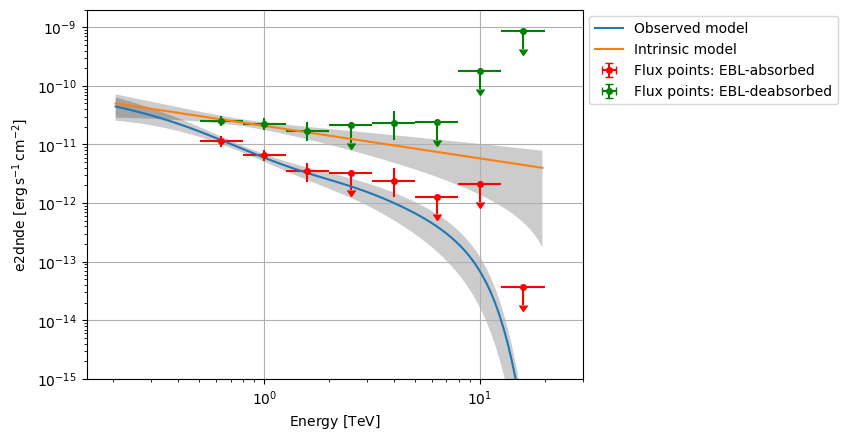

In [22]:
analysis.flux_points[0].plot(sed_type="e2dnde", color="red", label="Flux points: EBL-absorbed")
analysis.flux_points_deabs[0].plot(sed_type="e2dnde", color="green", label="Flux points: EBL-deabsorbed")

sed_kwargs["label"] = ""
analysis.final_model[0].spectral_model.plot_error(**sed_kwargs)
sed_kwargs["label"] = "Observed model"
analysis.final_model[0].spectral_model.plot(**sed_kwargs)
sed_kwargs["label"] = "Intrinsic model"
analysis.model_deabs.spectral_model.plot(**sed_kwargs)
sed_kwargs["label"] = ""
analysis.model_deabs.spectral_model.plot_error(**sed_kwargs)

plt.grid()
plt.legend(bbox_to_anchor=(1, 1))
plt.xlim(e_plot_min, e_plot_max)
plt.ylim(1e-15, 2e-9)

# Further extension
## Vary the EBL scale factor and redshift

In [23]:
cat_ = SourceCatalog4FGL()
pks_spec = cat_["PKS 2155-304"]

In [24]:
pks_obs_model = pks_spec.spectral_model() * EBLAbsorptionNormSpectralModel.read_builtin(
    "dominguez", redshift=base_config.target.components[0].spectral.ebl_abs.redshift
)

In [25]:
# Add a prior on alpha and beta
pks_obs_model.model1.alpha.prior = GaussianPrior(
    mu=pks_obs_model.model1.alpha.value, sigma=pks_obs_model.model1.alpha.error
)
pks_obs_model.model1.beta.prior = GaussianPrior(
    mu=pks_obs_model.model1.beta.value, sigma=pks_obs_model.model1.beta.error
)

In [26]:
# Allow redshift to vary
pks_obs_model.model2.redshift.frozen = False

In [27]:
print(pks_obs_model)

CompoundSpectralModel
    Component 1 : LogParabolaSpectralModel

type    name     value         unit        error   min max frozen is_norm link     prior    
---- --------- ---------- -------------- --------- --- --- ------ ------- ---- -------------
     amplitude 1.2591e-11 MeV-1 s-1 cm-2 1.317e-13 nan nan  False    True                   
     reference 1.1610e+03            MeV 0.000e+00 nan nan   True   False                   
         alpha 1.7733e+00                1.029e-02 nan nan  False   False      GaussianPrior
          beta 4.1893e-02                3.743e-03 nan nan  False   False      GaussianPrior
    Component 2 : EBLAbsorptionNormSpectralModel

type    name      value    unit   error   min max frozen is_norm link prior
---- ---------- ---------- ---- --------- --- --- ------ ------- ---- -----
     alpha_norm 1.0000e+00      0.000e+00 nan nan   True   False           
       redshift 1.1600e-01      0.000e+00 nan nan  False   False           
    Operator : mul



In [28]:
obs_model = SkyModel(spectral_model=pks_obs_model, name="Observed")

In [29]:
analysis.datasets.models = obs_model

In [30]:
%%time
result = analysis.fit.run(analysis.datasets)

CPU times: user 262 ms, sys: 1.12 ms, total: 263 ms
Wall time: 262 ms


In [31]:
result

In [32]:
total_stat = result.total_stat

In [33]:
par = obs_model.parameters["redshift"]
par.scan_max = par.value + 5.0 * par.error
par.scan_min = max(0, par.value - 5.0 * par.error)
par.scan_n_values = 310

In [34]:
%%time
profile = analysis.fit.stat_profile(
    datasets=analysis.datasets,
    parameter=obs_model.parameters["redshift"],
    reoptimize=True,
)

CPU times: user 38 s, sys: 239 ms, total: 38.2 s
Wall time: 38.3 s


Text(0, 0.5, '$\\Delta$ TS')

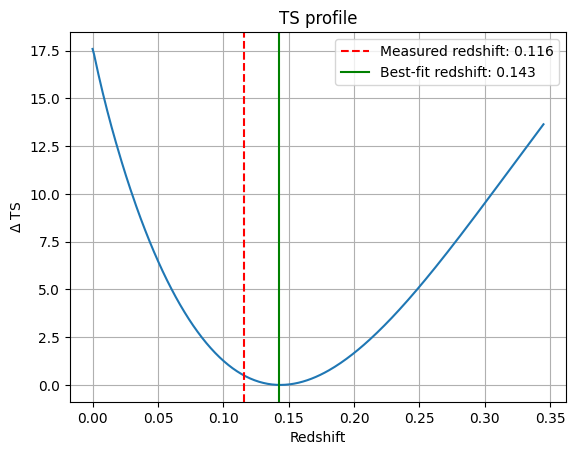

In [35]:
stat_diff = profile["stat_scan"] - total_stat
plt.plot(profile["Observed.spectral.redshift_scan"], stat_diff)

meas_redshift = base_config.target.components[0].spectral.ebl_abs.redshift
plt.axvline(
    meas_redshift,
    ls="--",
    color="red",
    label=f"Measured redshift: {meas_redshift}",
)
best_x = np.where(stat_diff == stat_diff.min())[0][0]
best_redshift = profile["Observed.spectral.redshift_scan"][best_x]
plt.axvline(
    best_redshift,
    ls="-",
    color="green",
    label=f"Best-fit redshift: {best_redshift:.3f}",
)

plt.title("TS profile")
plt.grid()
plt.legend()
plt.xlabel("Redshift")
plt.ylabel("$\Delta$ TS")